GERMAN TRAFFIC SIGN CLASSIFICATION

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
import random
import requests
import cv2
import pickle
from PIL import Image

In [2]:
np.random.seed(0)

## LOAD DATA

> Pickled Dataset is cloned from https://bitbucket.org/jadslim/german-traffic-signs.  
* train.p - Training set  
* test.p  - Test set  
* valid.p - Validation set  
* Signnames.csv - Traffic sign Names

In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [4]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
    
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)    

## DATA EXPLORATION

The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [6]:
print(type(train_data))

<class 'dict'>


In [7]:
train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [8]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [10]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to number of labels."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to number of labels."
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3."
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3."
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3."

In [11]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data.head())

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


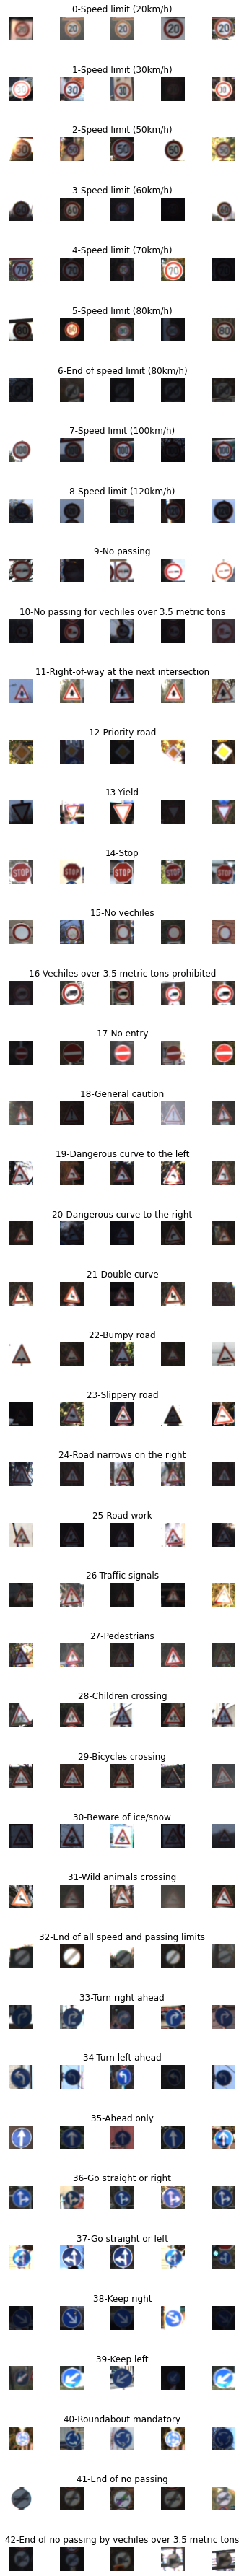

In [12]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, ax = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        ax[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        ax[j][i].axis("off")
        if i == 2:
            ax[j][i].set_title(str(j) + '-' + row["SignName"])
            num_of_samples.append(len(x_selected))

##### DISTRIBUTION OF CLASSES (TRFFIC SIGNS)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


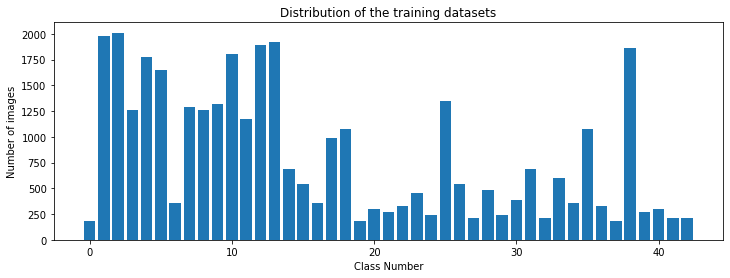

In [13]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training datasets")
plt.xlabel("Class Number")
plt.ylabel("Number of images")
plt.show()

## DATA PREPROCESSING

(32, 32, 3)
41


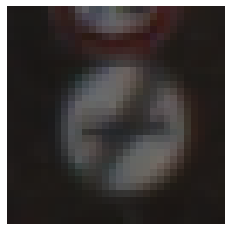

In [14]:
plt.imshow(X_train[0])
plt.axis('off')

print(X_train[0].shape)
print(y_train[0])

##### GRAY SCALE CONVERSION 

In [15]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(-0.5, 31.5, 31.5, -0.5)

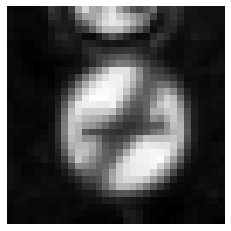

In [16]:
img = grayscale(X_train[0])
plt.imshow(img, cmap = 'gray')
plt.axis('off')

##### HISTOGRAM EQUALIZATION

In [17]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(-0.5, 31.5, 31.5, -0.5)

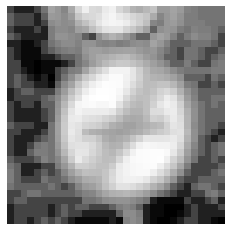

In [18]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')

##### NORMALIZE

(-0.5, 31.5, 31.5, -0.5)

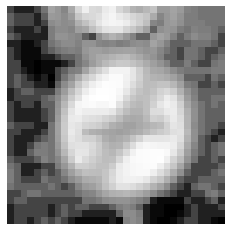

In [19]:
def normalize(img):
    img = img/255
    return img
img = normalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')

In [20]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = normalize(img)
    return img

In [21]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(-0.5, 31.5, 31.5, -0.5)

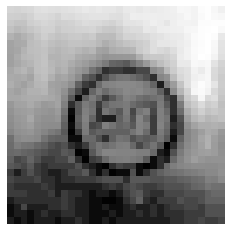

In [22]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap = 'gray')
plt.axis("off")

In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32)
(4410, 32, 32)
(12630, 32, 32)


In [24]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [25]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


##### ONE-HOT ENCODING

In [26]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## MODELING - leNet MODEL

The six layers of LeNet-4 were as follows:  
1. Layer C1: Convolution Layer (num_kernels=30, kernel_size=5×5, padding=0, stride=1)  
2. Layer S2: Max Pooling Layer (kernel_size=2×2, padding=0, stride=2)  
3. Layer C3: Convolution Layer (num_kernels=15, kernel_size=5×5, padding=0, stride=1)  
4. Layer S4: Max Pooling Layer (kernel_size=2×2, padding=0, stride=2)
5. Layer F5: Fully Connected Layer (out_features=512)  
6. Layer F6: Fully Connected Layer (out_features=43)  

In [27]:
def leNet_model(filters_l1, filters_l2, units_fc, lr):
    model = Sequential()
    
    # First Convolutional and Pooling Layer
    model.add(Conv2D(filters_l1, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # Second Convolution and Pooling Layer
    model.add(Conv2D(filters_l2, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # Flatten Images
    model.add(Flatten())
    
    # Fully Connected Layer 
    model.add(Dense(units_fc, activation = 'relu'))
    
    # Dropout Layer
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Compile Model
    model.compile(Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [28]:
model = leNet_model(filters_l1 = 30, filters_l2 = 15, units_fc = 512, lr = 0.01)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 540)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               276992    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [29]:
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 500, verbose = 1, shuffle = 1)

Epoch 1/10
70/70 [==============================] - 16s 15ms/step - loss: 3.2359 - accuracy: 0.1478 - val_loss: 1.2943 - val_accuracy: 0.5914
Epoch 2/10
70/70 [==============================] - 0s 7ms/step - loss: 1.1248 - accuracy: 0.6381 - val_loss: 0.7654 - val_accuracy: 0.7755
Epoch 3/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.7775 - val_loss: 0.5677 - val_accuracy: 0.8288
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4771 - accuracy: 0.8458 - val_loss: 0.5312 - val_accuracy: 0.8392
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4076 - accuracy: 0.8707 - val_loss: 0.4971 - val_accuracy: 0.8628
Epoch 6/10
70/70 [==============================] - 0s 7ms/step - loss: 0.3476 - accuracy: 0.8872 - val_loss: 0.4438 - val_accuracy: 0.8814
Epoch 7/10
70/70 [==============================] - 0s 7ms/step - loss: 0.2925 - accuracy: 0.9038 - val_loss: 0.4545 - val_accuracy: 0.8735
Epoch 8/10
70/70 [

Text(0.5, 0, 'Epoch')

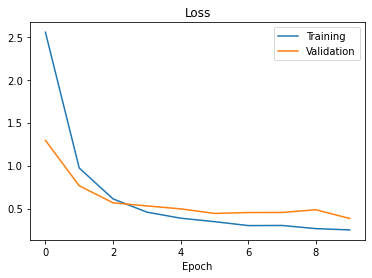

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

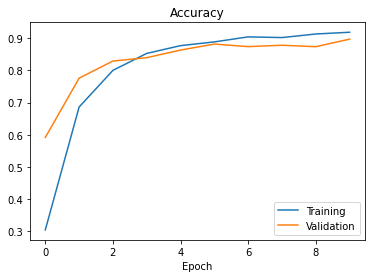

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')

##### EVALUATE PERFORMANCE ON TEST DATA

In [32]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.5429210662841797
Test Accuracy: 0.8719714879989624


Model is over fitting. Validation accuracy is less than training accuracy. Test accuracy is low too. Scope for improving accuracy.

## FINE TUNING MODEL

In [33]:
def ft_leNet_model(filters_l1, filters_l2, units_fc, lr):
    model = Sequential()
    
    # First Convolutional and Pooling Layer
    model.add(Conv2D(filters_l1, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(filters_l1, (5, 5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # Second Convolution and Pooling Layer
    model.add(Conv2D(filters_l2, (3, 3), activation = 'relu'))
    model.add(Conv2D(filters_l2, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # Dropout Layer
    model.add(Dropout(0.5))
    
    # Flatten Images
    model.add(Flatten())
    
    # Fully Connected Layer 
    model.add(Dense(units_fc, activation = 'relu'))
    
    # Dropout Layer
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Compile Model
    model.compile(Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [34]:
ft_model = ft_leNet_model(filters_l1 = 64, filters_l2 = 32, units_fc = 512, lr = 0.001)
print(ft_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 32)         

In [35]:
history = ft_model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 500, verbose = 1, shuffle = 1)

Epoch 1/10
70/70 [==============================] - 3s 26ms/step - loss: 3.2357 - accuracy: 0.1540 - val_loss: 0.8544 - val_accuracy: 0.7596
Epoch 2/10
70/70 [==============================] - 1s 14ms/step - loss: 0.9351 - accuracy: 0.7142 - val_loss: 0.3532 - val_accuracy: 0.8975
Epoch 3/10
70/70 [==============================] - 1s 14ms/step - loss: 0.4865 - accuracy: 0.8486 - val_loss: 0.1837 - val_accuracy: 0.9481
Epoch 4/10
70/70 [==============================] - 1s 14ms/step - loss: 0.3281 - accuracy: 0.8965 - val_loss: 0.1364 - val_accuracy: 0.9599
Epoch 5/10
70/70 [==============================] - 1s 14ms/step - loss: 0.2402 - accuracy: 0.9266 - val_loss: 0.1106 - val_accuracy: 0.9712
Epoch 6/10
70/70 [==============================] - 1s 14ms/step - loss: 0.2032 - accuracy: 0.9369 - val_loss: 0.0915 - val_accuracy: 0.9762
Epoch 7/10
70/70 [==============================] - 1s 14ms/step - loss: 0.1683 - accuracy: 0.9459 - val_loss: 0.0723 - val_accuracy: 0.9800
Epoch 8/10
70

Text(0.5, 0, 'Epoch')

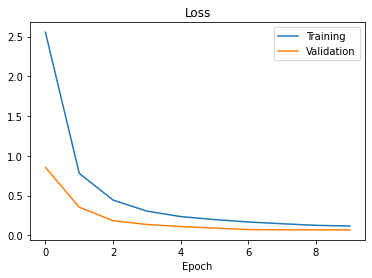

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

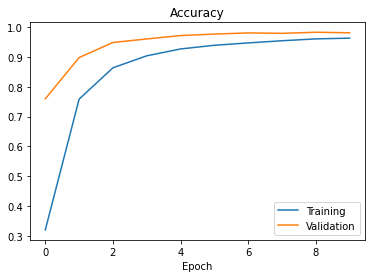

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')

##### EVALUATE PERFORMANCE ON TEST DATA

In [38]:
score = ft_model.evaluate(X_test, y_test, verbose = 0)
print('Test Score of fine tuned model:', score[0])
print('Test Accuracy of fine tuned model:', score[1])

Test Score of fine tuned model: 0.1378837376832962
Test Accuracy of fine tuned model: 0.9594615697860718


Validation accuracy is greater than Training accuracy. Model performs very well on test data too.

##### PREDICT IMAGE1

(-0.5, 1299.5, 955.5, -0.5)

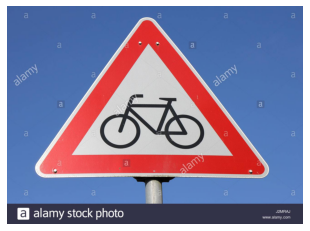

In [39]:
# Fetch Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


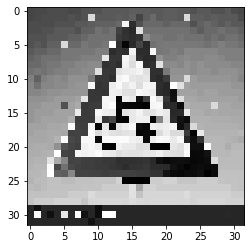

In [40]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [41]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [42]:
# Test Image
pred = np.argmax(ft_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [19]
19    Dangerous curve to the left
Name: SignName, dtype: object


##### PREDICT IMAGE2

(-0.5, 1299.5, 955.5, -0.5)

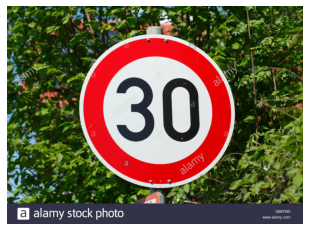

In [43]:
# Fetch Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


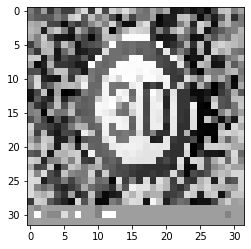

In [44]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [45]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [46]:
# Test Image
pred = np.argmax(ft_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [1]
1    Speed limit (30km/h)
Name: SignName, dtype: object


##### PREDICT IMAGE3

(-0.5, 1299.5, 865.5, -0.5)

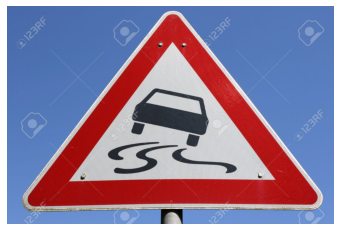

In [47]:
# Fetch Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


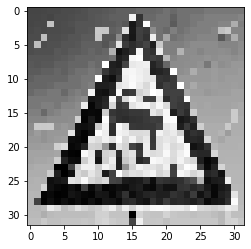

In [48]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [49]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [50]:
# Test Image
pred = np.argmax(ft_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [23]
23    Slippery road
Name: SignName, dtype: object


##### PREDICT IMAGE4

(-0.5, 1299.5, 878.5, -0.5)

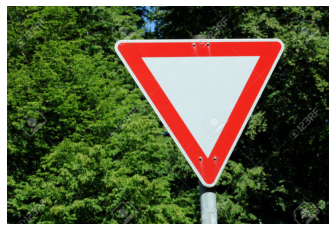

In [51]:
# Fetch Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


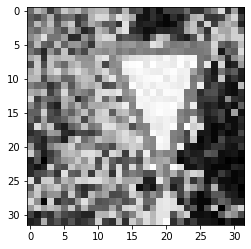

In [52]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [53]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [54]:
# Test Image
pred = np.argmax(ft_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [2]
2    Speed limit (50km/h)
Name: SignName, dtype: object


## MODELING USING IMAGE GENERATOR

In [55]:
X_train.shape

(34799, 32, 32, 1)

In [56]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1, 
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10, 
                   horizontal_flip = True)

datagen.fit(X_train)

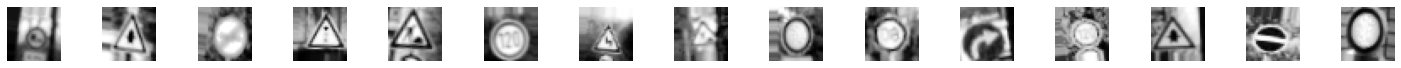

In [57]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, ax = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
    ax[i].imshow(X_batch[i].reshape(32, 32), cmap = 'gray')
    ax[i].axis('off')    

In [58]:
def final_leNet_model(filters_l1, filters_l2, units_fc, lr):
    model = Sequential()
    
    # First Convolutional and Pooling Layer
    model.add(Conv2D(filters_l1, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(filters_l1, (5, 5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    # Second Convolution and Pooling Layer
    model.add(Conv2D(filters_l2, (3, 3), activation = 'relu'))
    model.add(Conv2D(filters_l2, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Flatten Images
    model.add(Flatten())
    
    # Fully Connected Layer 
    model.add(Dense(units_fc, activation = 'relu'))
    
    # Dropout Layer
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Compile Model
    model.compile(Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [59]:
final_model = final_leNet_model(filters_l1 = 72, filters_l2 = 36, units_fc = 512, lr = 0.001)
print(final_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 72)        1872      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 72)        129672    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 72)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 36)        23364     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 36)          11700     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 36)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

In [60]:
history = final_model.fit(datagen.flow(X_train, y_train, batch_size = 70),
                          epochs=10,
                          validation_data=(X_val, y_val), 
                          shuffle = 1)

Epoch 1/10
498/498 [==============================] - 14s 25ms/step - loss: 2.8987 - accuracy: 0.2112 - val_loss: 0.6491 - val_accuracy: 0.8054
Epoch 2/10
498/498 [==============================] - 12s 23ms/step - loss: 0.9696 - accuracy: 0.6947 - val_loss: 0.3255 - val_accuracy: 0.8871
Epoch 3/10
498/498 [==============================] - 12s 24ms/step - loss: 0.5944 - accuracy: 0.8075 - val_loss: 0.2298 - val_accuracy: 0.9272
Epoch 4/10
498/498 [==============================] - 12s 24ms/step - loss: 0.4256 - accuracy: 0.8586 - val_loss: 0.1797 - val_accuracy: 0.9376
Epoch 5/10
498/498 [==============================] - 12s 24ms/step - loss: 0.3627 - accuracy: 0.8807 - val_loss: 0.1675 - val_accuracy: 0.9349
Epoch 6/10
498/498 [==============================] - 12s 24ms/step - loss: 0.3161 - accuracy: 0.8989 - val_loss: 0.1297 - val_accuracy: 0.9583
Epoch 7/10
498/498 [==============================] - 12s 23ms/step - loss: 0.2666 - accuracy: 0.9128 - val_loss: 0.1797 - val_accuracy:

Text(0.5, 0, 'Epoch')

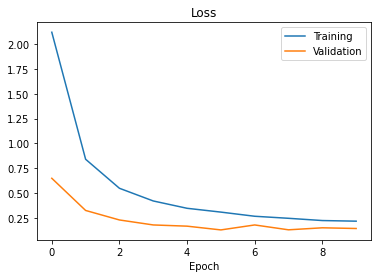

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

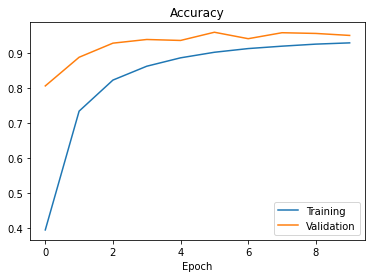

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')

##### EVALUATE PERFORMANCE ON TEST DATA

In [63]:
score = final_model.evaluate(X_test, y_test, verbose = 0)
print('Test Score of fine tuned model:', score[0])
print('Test Accuracy of fine tuned model:', score[1])

Test Score of fine tuned model: 0.2390734851360321
Test Accuracy of fine tuned model: 0.9226444959640503


##### PREDICT IMAGE1

(-0.5, 1299.5, 955.5, -0.5)

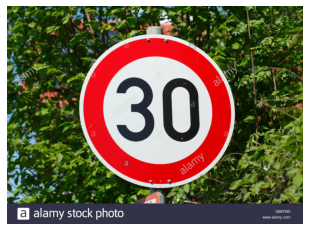

In [64]:
# Fetch Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


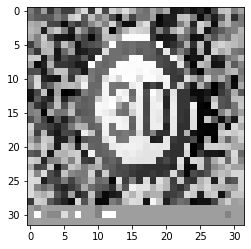

In [65]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [66]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [67]:
# Test Image
pred = np.argmax(final_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [1]
1    Speed limit (30km/h)
Name: SignName, dtype: object


##### PREDICT IMAGE2

(-0.5, 1299.5, 945.5, -0.5)

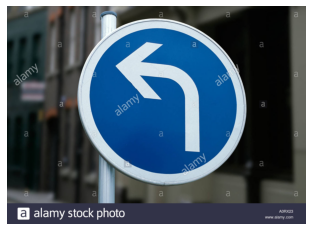

In [68]:
# Fetch Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


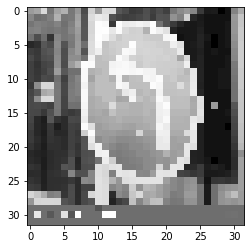

In [69]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [70]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [71]:
# Test Image
pred = np.argmax(final_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [35]
35    Ahead only
Name: SignName, dtype: object


##### PREDICT IMAGE3

(-0.5, 1299.5, 865.5, -0.5)

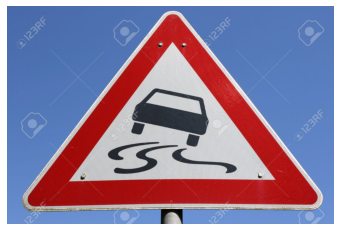

In [72]:
# Fetch Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


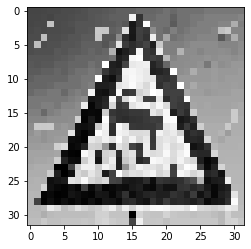

In [73]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [74]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [75]:
# Test Image
pred = np.argmax(final_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [23]
23    Slippery road
Name: SignName, dtype: object


##### PREDICT IMAGE4

(-0.5, 1299.5, 878.5, -0.5)

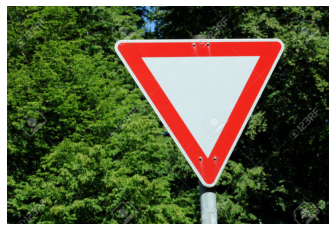

In [76]:
# Fetch Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


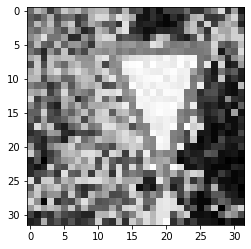

In [77]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [78]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [79]:
# Test Image
pred = np.argmax(final_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [13]
13    Yield
Name: SignName, dtype: object


##### PREDICT IMAGE5

(-0.5, 1299.5, 955.5, -0.5)

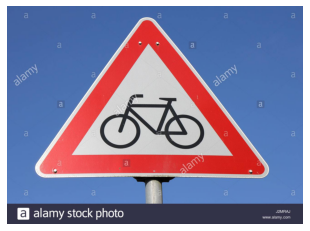

In [80]:
# Fetch Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')

(32, 32)


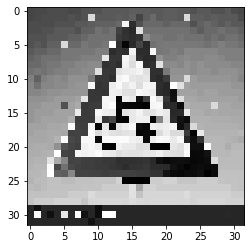

In [81]:
# Preprocess Image 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [82]:
# Reshape Image
img = img.reshape(1, 32, 32, 1)

In [83]:
# Test Image
pred = np.argmax(final_model.predict(img), axis = 1)
print("Predicted sign: ", pred)
print(data['SignName'][pred])

Predicted sign:  [29]
29    Bicycles crossing
Name: SignName, dtype: object
